# PC Session 3

**Authors:**
Jonathan Chassot, [Helge Liebert](https://hliebert.github.io/), and [Anthony Strittmatter](http://www.anthonystrittmatter.com)

# **Text analysis**

In [1]:
## Libraries
library(tm)
library(data.table)
library(ggplot2)
library(tidytext)
library(dplyr)
library(topicmodels)
library(wordcloud)
library(SentimentAnalysis)
library(naivebayes)
library(slam)
library(glmnet)
library(lexicon)


Attaching package: ‘ggplot2’

The following object is masked from ‘package:NLP’:

    annotate


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘SentimentAnalysis’

The following object is masked from ‘package:base’:

    write


Attaching package: ‘naivebayes’

The following object is masked from ‘package:data.table’:

    tables


Attaching package: ‘slam’

The following object is masked from ‘package:data.table’:

    rollup

Loaded glmnet 2.0-16



In [2]:
## Simple helper function to view first copora elements, only for illustration in lecture
chead <- function(c) lapply(c[1:2], as.character)

In [3]:
## Read data
loans <- fread("Data/kiva-tiny.csv")
#loans <- fread("Data/kiva-small.csv")
names(loans)

[1] "loanid"            "description"       "fundedamount"     
[4] "loanamount"        "activityname"      "sectorname"       
[7] "loanuse"           "countryname"       "repaymentinterval"

In [4]:
## Set up corpus
setnames(loans, "loanid", "doc_id")
setnames(loans, "description", "text")
corp <- Corpus(DataframeSource(loans))

## Inspect it
corp
lapply(corp[1:2], as.character)

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 7
Content:  documents: 10000

$`269894`
[1] "Esteban belongs to the “Las Margarita Ocongate” community bank and lives in the city of Ocongate, in Quispicanchis province, in Cusco department, Peru. He lives with his wife and his 5 year-old daughter Crisanta. The city of Ocongate is two hours from the city of Cusco. Esteban studied law at the National University of San Antonio Abad in Cusco but he was unable to complete his degree for financial reasons. He decided to start a new life. Esteban worked helping lawyers write documentation and then trained to become a legal counselor (someone who provides advice on legal matters including criminal issues, civil issues, labor issues, contracts, transfers, fees, and other cases). After working in different cities in Cusco department as a legal counselor, Esteban decided to set up in the city of Ocongate and opened a legal counseling office. Esteban requires this loan to buy stationery supplies such as paper, pens and many other products. Esteban is grateful for this opportunity and he pledges to make his repayments on time."

$`1247640`
[1] "Kosar is a married woman and entrepreneur and a new borrower through BRAC Pakistan. She has worked hard day-and-night to manage the household expenses. Kosar recently opened a salon and needs to decorate the interior and buy stock of cosmetics and beauty-related electronics. Kosar has requested for a loan from BRAC Pakistan to help establish her salon business by fixing up the interior, for which she needs to buy salon chairs and cosmetics to attract more customers. This is Kosar’s first loan, and she is very happy to have support from BRAC Pakistan and Kiva."

In [5]:
## Main corpus transformations, passed via tm_map()
## Other transformations have to be wrapped in content_transformer()
getTransformations()

[1] "removeNumbers"     "removePunctuation" "removeWords"      
[4] "stemDocument"      "stripWhitespace"

In [6]:
## All chars to lower case
corp <- tm_map(corp, content_transformer(tolower))
## chead(corp)

In [7]:
## Remove punctuation
corp <- tm_map(corp, removePunctuation)
## chead(corp)
## corp <- tm_map(corp, removePunctuation, ucp = TRUE)
## chead(corp)

In [8]:
## Remove numbers
corp <- tm_map(corp, removeNumbers)
## chead(corp)

In [9]:
## For specific transformations, you could also pass a lambda function to remove patterns based on a regex

## Example:
## toSpace <- content_transformer(function (x , pattern) gsub(pattern, " ", x))
## corp <- tm_map(corp, toSpace, "patternhere")

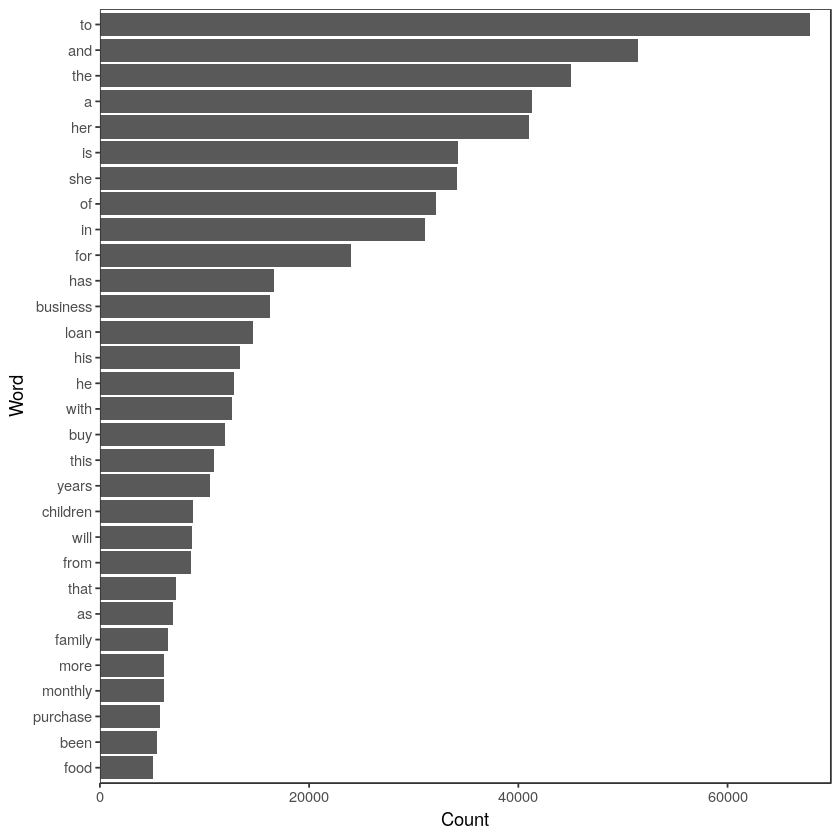

In [10]:
## Look at the most frequent words in our text and see whether we should get rid of some
frequent_terms <- qdap::freq_terms(corp, 30)
plot(frequent_terms)

In [11]:
## More invasive changes: remove generic and custom stopwords
corp <- tm_map(corp, removeWords, stopwords('english'))
## chead(corp)

In [12]:
## And a few more words we filter for lack of being informative, this could be extended
corp <- tm_map(corp, removeWords, "loan")
corp <- tm_map(corp, removeWords, "kiva")

In [13]:
## There are a lot of names in the data, these are not really informative
## We apply a dictionary to get rid of some of them
corp <- tm_map(corp, removeWords, common_names[1:floor(length(common_names)/2)])
corp <- tm_map(corp, removeWords, common_names[floor(length(common_names)/2):length(common_names)])
corp <- tm_map(corp, removeWords, freq_first_names[1:floor(nrow(freq_first_names)/2), Name])
corp <- tm_map(corp, removeWords, freq_first_names[floor(nrow(freq_first_names)/2):nrow(freq_first_names), Name])
## corp <- tm_map(corp, removeWords, freq_last_names) # needs to be truncated as well, even longer
## chead(corp)

In [14]:
## Stem document
## corp <- tm_map(corp, stemDocument, language = 'english')
## chead(corp)

In [15]:
## Strip extra whitespace
corp <- tm_map(corp, stripWhitespace)
## chead(corp)

In [16]:
## Build a document-term or term-document matrix
## Default is term-frequency weighting (document length normalized count)
## dtm <- TermDocumentMatrix(corp)
dtm <- DocumentTermMatrix(corp)

## Inspect the document-term matrix
inspect(dtm)

<<DocumentTermMatrix (documents: 10000, terms: 23589)>>
Non-/sparse entries: 516846/235373154
Sparsity           : 100%
Maximal term length: 121
Weighting          : term frequency (tf)
Sample             :
         Terms
Docs      business buy children family help income lives married old years
  1037639        0   0        1      3    0      0     0       1   2     3
  137566         2   4        6      3    0      0     3       3   5     5
  141930         0   1        1      0    1      0     1       2   3     2
  152994         0   5        3      0    1      0     0       1   1     3
  219458         0   0        0      0    0      0     0       5   0     5
  264698         0   0        4      3    2      1     1       0   0     0
  472746         1   0        0      3    2      0     0       0   0     1
  489429         0   2        0      1    0      1     1       0   0     1
  87540          4   1        1      1    1      1     0       1   1     2
  96153          1   1      

In [17]:
## Inspect most popular words
findFreqTerms(dtm, lowfreq=1000)

[1] "buy"         "city"        "community"   "financial"   "life"       
  [6] "lives"       "make"        "new"         "products"    "time"       
 [11] "two"         "working"     "yearold"     "business"    "customers"  
 [16] "expenses"    "first"       "hard"        "help"        "married"    
 [21] "needs"       "requested"   "support"     "woman"       "can"        
 [26] "family"      "hardworking" "increase"    "loans"       "requesting" 
 [31] "selling"     "well"        "farm"        "farmer"      "get"        
 [36] "husband"     "income"      "old"         "order"       "sells"      
 [41] "village"     "years"       "expand"      "future"      "like"       
 [46] "money"       "now"         "nwtf"        "philippines" "php"        
 [51] "save"        "sell"        "store"       "works"       "also"       
 [56] "capital"     "children"    "earns"       "education"   "group"      
 [61] "hopes"       "local"       "members"     "pay"         "provide"    
 [66] "used"        "work"        "farming"     "four"        "good"       
 [71] "improve"     "three"       "day"         "house"       "living"     
 [76] "one"         "profits"     "purchase"    "rice"        "school"     
 [81] "food"        "items"       "area"        "five"        "mother"     
 [86] "partner"     "wants"       "enough"      "additional"  "able"       
 [91] "continue"    "year"        "member"      "shop"        "use"        
 [96] "since"       "small"       "earn"        "sales"       "market"     
[101] "plans"       "home"        "better"      "water"

In [53]:
## Inspect associations
findAssocs(dtm, 'hard', 0.15)

$hard
       nwtf philippines      attain      parent  sustaining       works 
       0.41        0.39        0.38        0.37        0.35        0.28 
        php      enough     general     provide   requested   borrowing 
       0.27        0.24        0.23        0.22        0.21        0.21 
       save      afford        send        work     vending     college 
       0.20        0.20        0.20        0.19        0.19        0.18 
       like     working       money  faithfully  additional      secure 
       0.17        0.16        0.16        0.16        0.16        0.16 
  groceries     expands     minimum       loans      future       store 
       0.16        0.16        0.16        0.15        0.15        0.15 
       word continually 
       0.15        0.15

In [19]:
## Remove sparse terms,improves tractability and saves time
## Tweak the sparse parameter to influence # of words
dtms <- removeSparseTerms(dtm, sparse=0.90)
dim(dtms)
dtms <- dtms[row_sums(dtms) > 0, ]
dim(dtms)

[1] 10000    88

[1] 9999   88

In [20]:
## Alternatively, filter words by mean tf-idf
## Calculate average term-specific tf-idf weights as
## mean(word count/document length) * log(ndocs/ndocs containing word)
termtfidf <- tapply(dtm$v/row_sums(dtm)[dtm$i], dtm$j, mean) *
             log2(nDocs(dtm)/col_sums(dtm > 0))
summary(termtfidf)

## Only include terms with above mean tf-idf score
dtmw <- dtm[, (termtfidf >= 0.30)]
dim(dtmw)
## And documents within which these terms occur - this may induce selection
dtmw <- dtmw[row_sums(dtmw) > 0, ]
dim(dtmw)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01578 0.13426 0.18688 0.26038 0.28069 2.29098 

[1] 10000  5276

[1] 5447 5276

In [21]:
findFreqTerms(dtmw, lowfreq=100)

[1] "rickshaw" "babban"   "aski"     "sanitary"

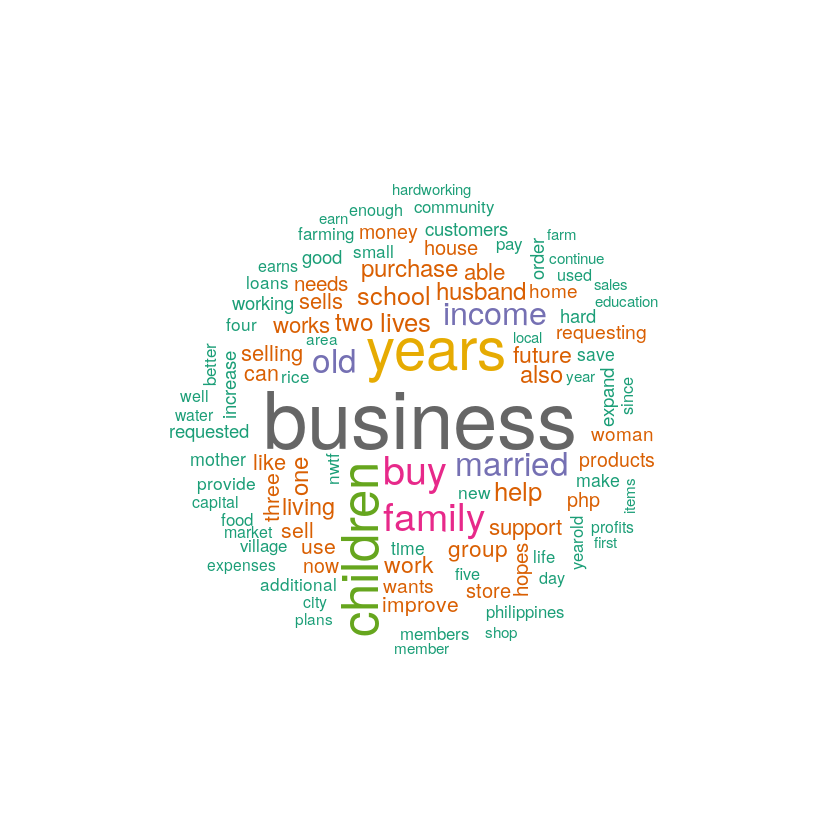

In [22]:
## Simple visualization
wordcloud(corp, max.words = 100, random.order = FALSE,
          colors = brewer.pal(8, "Dark2"))

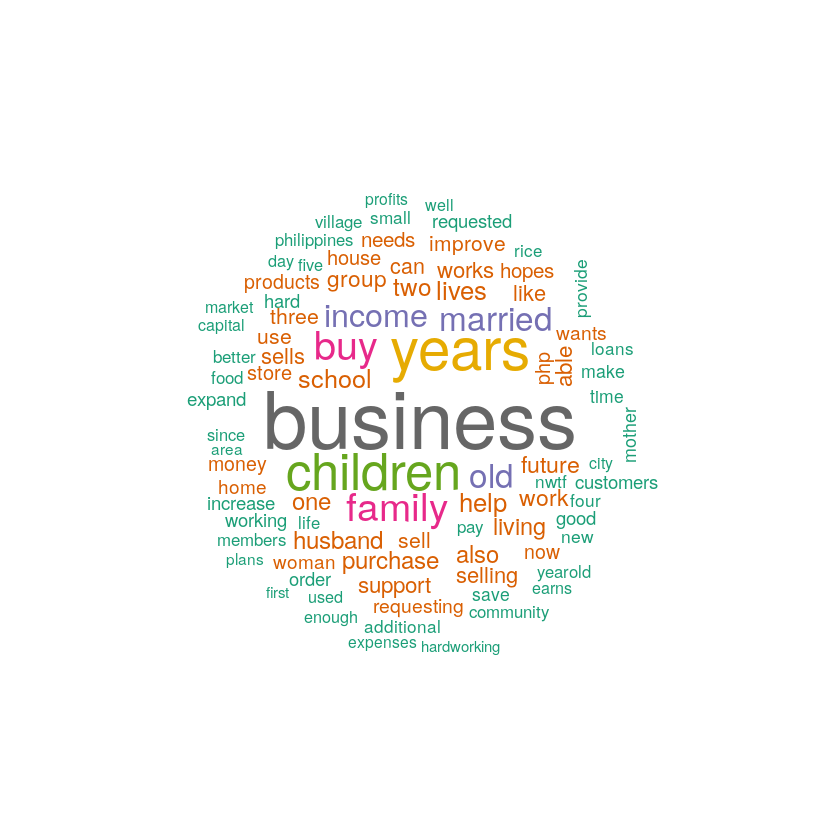

In [23]:
## Counts from dtms
counts <- sort(colSums(as.matrix(dtms)), decreasing = TRUE)
counts <- data.frame(word = names(counts), freq = counts)
wordcloud(words = counts$word, freq = counts$freq,
          max.words = 100, random.order = FALSE,
          colors = brewer.pal(8, "Dark2"))

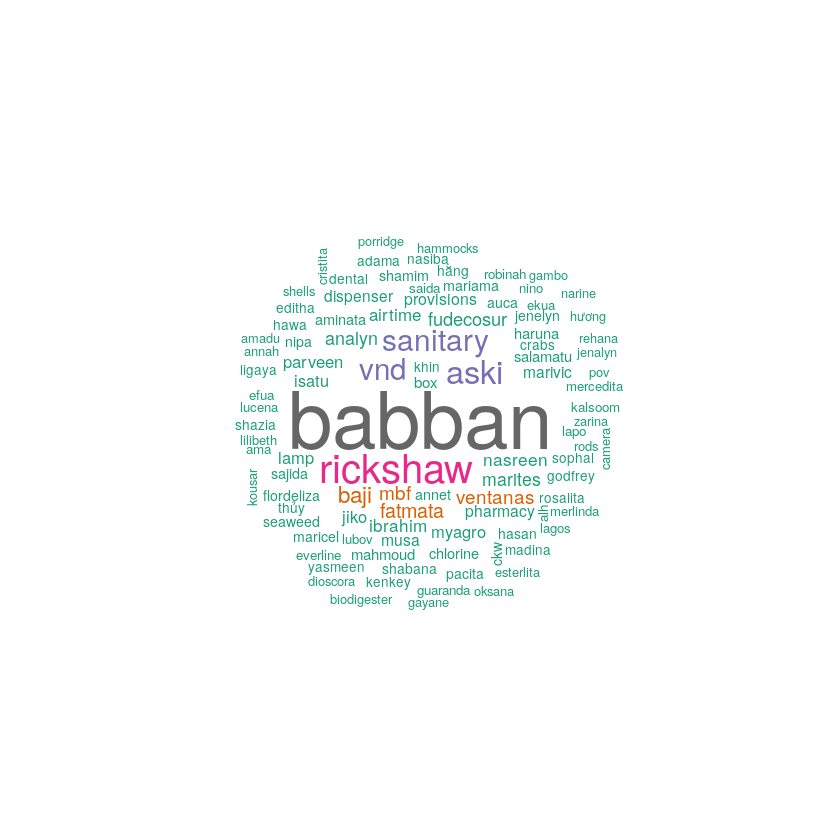

In [24]:
## Counts from dtmw
counts <- sort(colSums(as.matrix(dtmw)), decreasing = TRUE)
counts <- data.frame(word = names(counts), freq = counts)
wordcloud(words = counts$word, freq = counts$freq,
          max.words = 100, random.order = FALSE,
          colors = brewer.pal(8, "Dark2"))

In [25]:
## Dictionary method: Sentiment analysis using dictionaries
sentiment <- analyzeSentiment(dtms, language = "english")
sentiment <- convertToDirection(sentiment$SentimentGI)
## Potentially add back to original data for further analysis
## loans$sentiment <- sentiment
table(sentiment)

sentiment
negative  neutral positive 
     108     1386     8505 

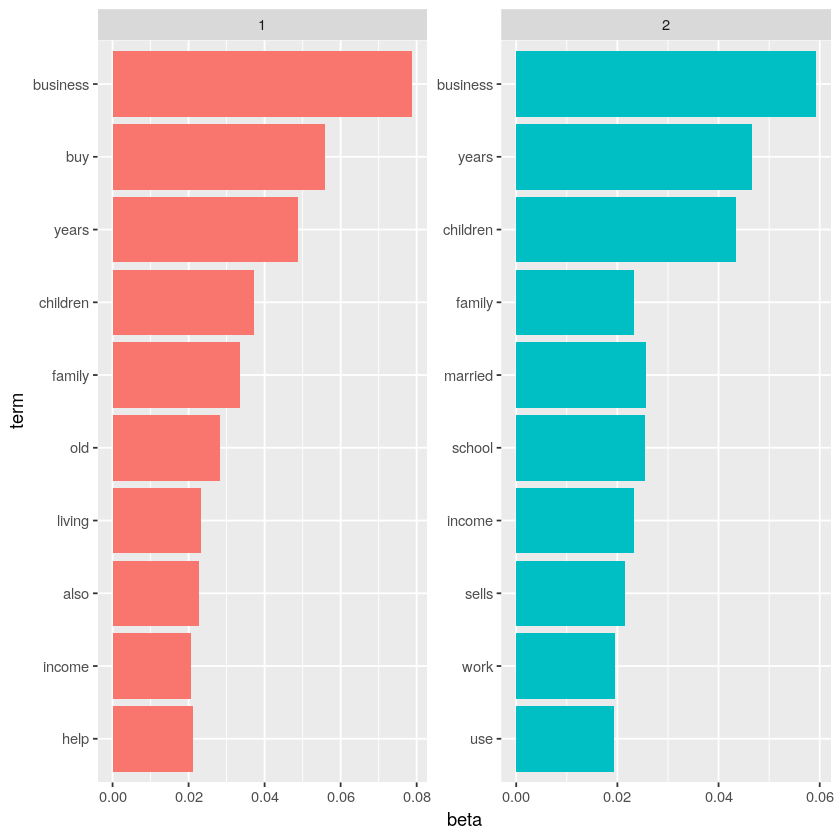

In [26]:
## Unsupervised method: Topic model
lda <- LDA(dtms, k = 2, control = list(seed = 100))
## lda <- LDA(dtms, k = 10, control = list(seed = 100))
## lda <- LDA(dtmw, k = 2, control = list(seed = 100))
## lda <- LDA(dtmw, k = 10, control = list(seed = 100))

## Most likely topic for each document, could merge this to original data
## topic <- topics(lda, 1)
## Five most frequent terms for each topic
## terms(lda, 5)

## Plot most frequent terms and associated probabilities by topic
tpm <- tidy(lda, matrix = "beta")

topterms <-
    tpm %>%
    group_by(topic) %>%
    top_n(10, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)

topterms %>%
    mutate(term = reorder(term, beta)) %>%
    ggplot(aes(term, beta, fill = factor(topic))) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") +
    coord_flip()

In [45]:
## Supervised methods: Prep data
## Convert the sparse term-document matrix to a standard data frame
bag <- as.data.frame(as.matrix(dtms))
dim(bag)

[1] 9999   88

In [46]:
## Convert token counts to simple binary indicators
bag <- as.data.frame(sapply(bag, function(x) as.numeric(x > 0)))
bag$doc_id <- rownames(as.matrix(dtms))

## Add outcomes from the original data: Predict agricultural sector
loans$agsector <- as.numeric(loans$sectorname=="Agriculture")
bag <- merge(bag, loans[, .(agsector, loanamount, doc_id)], by = "doc_id")
table(bag$agsector)


   0    1 
7510 2489 

In [47]:
## Partition data in test and training sample
set.seed(100)
testids <- sample(floor(nrow(bag)/3))
xtrain <- as.matrix(bag[-testids, !(names(bag) %in% c("agsector", "loanamount", "doc_id"))])
ytrain <- as.factor(bag[-testids,  "agsector"])
xtest  <- as.matrix(bag[ testids, !(names(bag) %in% c("agsector", "loanamount", "doc_id"))])
ytest  <- as.factor(bag[ testids,  "agsector"])

In [1]:
## Supervised generative model: Naive Bayes
nbclassifier <- naive_bayes(xtrain, ytrain)
# nbclassifier <- naive_bayes(xtrain, ytrain, laplace = 1)
nbpred <- predict(nbclassifier, xtest)
summary(nbpred)

ERROR: Error in naive_bayes(xtrain, ytrain): konnte Funktion "naive_bayes" nicht finden


In [49]:
## Performance statistics: Classification rate
round(1-mean(as.numeric(nbpred != ytest)), 2)

## Performance statistics: Confusion matrix
caret::confusionMatrix(nbpred, ytest)

[1] 0.66

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1668  335
         1  785  545
                                        
               Accuracy : 0.664         
                 95% CI : (0.6476, 0.68)
    No Information Rate : 0.736         
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.2571        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.6800        
            Specificity : 0.6193        
         Pos Pred Value : 0.8328        
         Neg Pred Value : 0.4098        
             Prevalence : 0.7360        
         Detection Rate : 0.5005        
   Detection Prevalence : 0.6010        
      Balanced Accuracy : 0.6497        
                                        
       'Positive' Class : 0             
                                        

In [50]:
## Supervised text regression: L1 penalized logistic regression
l1classifier <- cv.glmnet(xtrain, ytrain, alpha = 1, family = "binomial")
l1pred <- as.factor(predict(l1classifier, xtest, s = "lambda.min", type = "class"))
summary(l1pred)

0    1 
2896  437

In [51]:
## Performance statistics: Classification rate
round(1-mean(as.numeric(l1pred != ytest)), 2)

## Performance statistics: Confusion matrix
caret::confusionMatrix(l1pred, ytest)

[1] 0.79

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2321  575
         1  132  305
                                          
               Accuracy : 0.7879          
                 95% CI : (0.7736, 0.8017)
    No Information Rate : 0.736           
    P-Value [Acc > NIR] : 2.047e-12       
                                          
                  Kappa : 0.3491          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9462          
            Specificity : 0.3466          
         Pos Pred Value : 0.8015          
         Neg Pred Value : 0.6979          
             Prevalence : 0.7360          
         Detection Rate : 0.6964          
   Detection Prevalence : 0.8689          
      Balanced Accuracy : 0.6464          
                                          
       'Positive' Class : 0               
                                          

In [1]:
## L1 logistic classifier using rare feature upweighting
sdweights <- apply(xtrain, 2, sd)
l1classifier <- cv.glmnet(xtrain, ytrain, alpha = 1, family = "binomial",
                          standardize = FALSE, penalty.factor  = sdweights)
l1pred <- as.factor(predict(l1classifier, xtest, s = "lambda.min", type = "class",
                            penalty.factor  = sdweights))
summary(l1pred)

ERROR: Error in apply(xtrain, 2, sd): Objekt 'xtrain' nicht gefunden


In [ ]:
## Performance statistics: Classification rate
1-mean(as.numeric(l1pred != ytest))
## Performance statistics: Confusion matrix
caret::confusionMatrix(l1pred, ytest)

In [52]:
## Further example: Predict Loan Amount
## Supervised text regression: L1 penalized linear regression

## Rebuild outcome vectors
#ytrain <- as.matrix(bag[-testids,  "loanamount"])
#ytest  <- as.matrix(bag[ testids,  "loanamount"])

## Estimate and predict
#l1predictor <- cv.glmnet(xtrain, ytrain, alpha = 1, family = "gaussian")
#l1pred <- predict(l1predictor, xtest, s = "lambda.min", type = "response")

## RMSE
#round(sqrt(mean((l1pred - ytest)^2)), 2)
#caret::postResample(l1pred, ytest)